# Control theory. Course introduction.

## TP3. Controllability and Observability
## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP2.ipynb)    

The completed notebooks should be sent to your tutor (elena.vanneaux@ensta.fr or adnan.saood@ensta.fr) before the beginning of the next session. Please add [APM_4AUT2_TA] to the topic of e-mail.

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

    5. Control System Library https://python-control.readthedocs.io/en/0.10.1/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

In [15]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# x is a state vecot, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix, 
# u_func(t) is a control input, w_func(t) is a disturbance input 
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    # return (C @ solution.T) 
    return (solution.T) 

def PID(A, B, D, C, Kp, Ki, Kd, r_func, w_func, T, x0):
    z0 = np.array([[0.0]])
    x_a =  np.block([[x0.reshape(-1,1)],[z0]])
    M = np.eye(x0.shape[0]) + Kd*B @ C
    A_a = np.block([[np.linalg.inv(M) @ (A - Kp * B @ C), -Ki * np.linalg.inv(M) @ B ], [C, np.array([0.0])]])
    B_a =  np.block([[Kp * np.linalg.inv(M) @ B ], [np.array([1.0])]])
    D_a = np.block([[np.linalg.inv(M) @ D],[np.array([[0.0]])]])
    C_a = np.block([C, np.array([[0.0]])])
    return OpenLoopInputOutputSystem(A_a, B_a, D_a, C_a, r_func, w_func, T, x_a.flatten()).T

Text(0, 0.5, 'Position ')

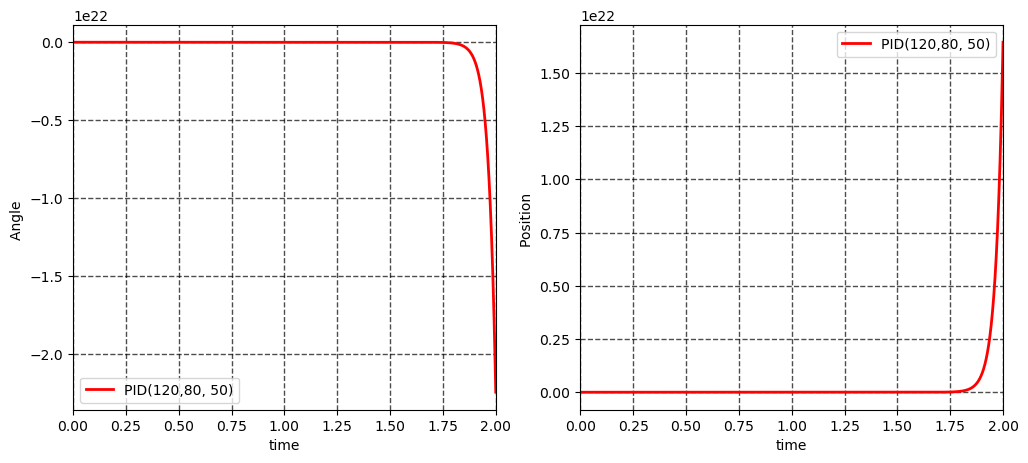

In [16]:
import sympy as sp
from matplotlib.pyplot import *
# Answer to EX1 q1 using symbolic calculs
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))

A = np.array(jacobian_A.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float)
B = np.array(jacobian_B.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float).reshape(4,1)
C = np.array([[1,0,0,0],[0,0,1,0]]) 
D = B

x0 = np.array([0,
               0,
               0,
               0])  # initial state

MatC = np.array([[0,0,1,0]]) # Let us assume that we measure only theta
y_ref = 1 # and we want to track constant reference equal to 1 rad. The latter correspond a state responce if the system

Kp= 120;
Ki = 80;
Kd = 50;

t0 = 0 # Initial time 
tf = 2 # Final time
T = np.linspace(t0, tf, 1000) 

def w_func(t):
       return 1.0# Disturbance input

def r_func(t):
       return 0.0# Disturbance input


solution = PID(A, B, D, MatC , Kp, Ki, Kd, r_func, w_func, T, x0)


figure(figsize=(12, 5))
y = solution[:,2]

subplot(1, 2, 1)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Angle ')

y = solution[:,0]
subplot(1, 2, 2)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Position ')

## Ex 1. Duality of Controllability and Observability

Prove that a pair of matrices (A,B) is controllable if and only if a pair of matrices (A^T, B^T) is observable.

We want to show that $(A,B)$ controllable $\Leftrightarrow$ $A^T,B^T$ controllable. 
This is equivalent to proving that $\text{rank}(\mathcal{C}(A,B)) = n \Leftrightarrow \text{rank}(\mathcal{C}(A^T,B^T)) = n$

### $\Rightarrow$ part
We assume that $\text{rank}(\mathcal{C}(A,B)) = n$ with $\mathcal{C}(A,B) = \begin{bmatrix} B & AB & A^2B & \dots & A^{n-1}B\end{bmatrix}$

We want to show that $\text{rank}(\mathcal{C}(A^T,B^T)) = n$

We have $$\mathcal{C}(A^T,B^T) = \begin{bmatrix} B^T & A^TB^T & {A^T}^2B^T & \dots & {A^T}^{n-1}B^T\end{bmatrix}$$

## Ex 2. Invariance Under Nonsingular Transformations.

Consider $\dot x = Ax + Bu$ and similarity transformation $\tilde x = Tx$, where $T$ is invertible.

Prove that the system $\dot x = Ax + Bu$ is controllable if and only if the system  $\dot {\tilde x} = \tilde{A}\tilde{x} + \tilde{B}u$ is controllable.

### Calculating $\tilde{A}$ and $\tilde{B}$
We have, by replacing $\tilde x$ by its expression in the second expression : $$T \dot x = \tilde{A}Tx+\tilde{B}u\quad \text{thus}\quad \dot x = T^{-1}\tilde{A}Tx + T^{-1}\tilde{B}u $$

By identifying the terms and rearranging, we get $$\tilde{A} = TAT^{-1} \quad\text{and}\quad \tilde{B} = TB$$

### Part 1 : $\Rightarrow$ 

Let's suppose that $\text{rank}(\mathcal{C}(A,B)) = n$, show that $\text{rank}(\mathcal{C}(\tilde{A},\tilde{B})) = n$

$\mathcal

## Ex 3. Quadruple-Tank Process

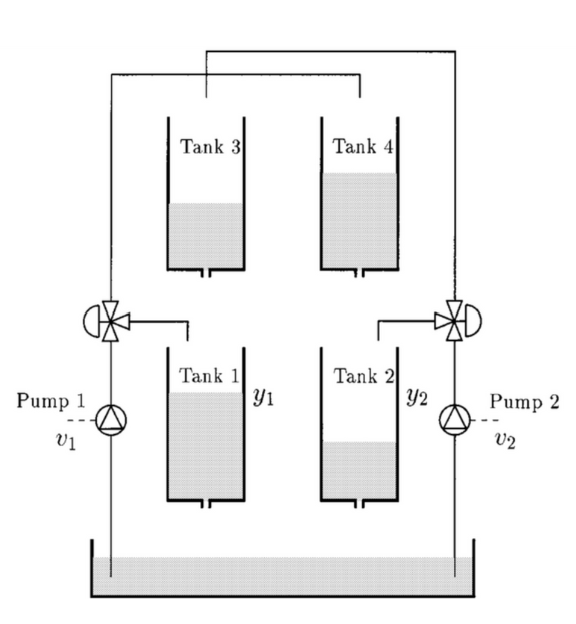

Let us consider the Quadruple-Tank Process. A schematic diagram of the process is shown in the Figure above. The
target is to control the level in the lower two tanks with two pumps. The process inputs are $v_1$ and $v_2$ (input voltages to the pumps) and the outputs are $y_1$ and $y_2$ (water levels in the lower two tanks). Mass balances and Bernoulli’s law yield:

$$
\dfrac{dh_1}{dt} = -\dfrac{a_1}{A_1}\sqrt{2gh_1} + \dfrac{a_3}{A_1}\sqrt{2gh_3} + \dfrac{\gamma_1k_1}{A_1}v_1 = f_1(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_2}{dt} = -\dfrac{a_2}{A_2}\sqrt{2gh_2} + \dfrac{a_4}{A_2}\sqrt{2gh_4} + \dfrac{\gamma_2k_2}{A_2}v_2 = f_2(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_3}{dt} = -\dfrac{a_3}{A_3}\sqrt{2gh_3} + \dfrac{(1-\gamma_2)k_2}{A_3}v_2 = f_3(h_1,h_2,h_3,h_4,v_1,v_2)
$$
$$
\dfrac{dh_4}{dt} = -\dfrac{a_4}{A_4}\sqrt{2gh_4} + \dfrac{(1-\gamma_1)k_1}{A_4}v_1 = f_4(h_1,h_2,h_3,h_4,v_1,v_2)
$$
where

$A_i$ is a cross-section of Tank i

$a_i$ is a cross-section of outlet hole of Tank i

$h_i$ is a water level.

The voltage applied to Pump $i$ is $v_i$ and the corresponding flow
is $k_iv_i$. The parameters $\gamma_1,\gamma_2\in (0,1)$ are determined from how the valves are set prior to experiment. The flow to Tank 1
is $\gamma_1k_1v_1$ and the flow to Tank 4 is $(1-\gamma_1)k_1v_1$ and similarly
for Tank 2 and Tank 3. The acceleration of gravity is denoted $g$.
The measured level signals are $k_c h_1$ and $k_c h_2$. The parameter
values of the laboratory process are given in the following table

    A_1, A_3 [cm^2] 28
    A_2, A_4 [cm^2] 32
    a_1, a_3 [cm^2] 0.071
    a_2, a_4 [cm^2] 0.057
    k_c [V/cm] 0.50
    g [cm/s^2] 9.81
    k_1 [cm^3/Vs] 3.33
    k_2 [cm^3/Vs] 3.35
    gamma_1 0.70
    gamma_2 0.60
    
Check the following paper for more details on the model. 
https://www.diva-portal.org/smash/get/diva2:495784/FULLTEXT01.pdf
    
## TODO
1. Linearise the system around the operating point 
$$(h_1^0,h_2^0,h_3^0,h_4^0, v_1^0, v_2^0) = (12.4,12.7,1.8,1.4,3.00,3.00).$$
Pass to shifted variables $x_i = h_i-h_i^0, u_i = v_i - v_i^0.$

2. Is the linear system controllable? Is the linear system observable? Use the Kalman rank test to answer this question.

3. Imagine that one of the pumps is broken and there is no flow through it. Does the system remain controllable?

4. Let us measure the signals $x_3, x_4$ (i.e. matix $C = \begin{pmatrix}0&0&1&0\\0&0&0&1\end{pmatrix}$) instead of measuring the signals $x_1$ and $x_2.$ Is such a system observable?

Remark. The functions control.ctrb and control.obsv from control system library might be useful to comple. https://python-control.readthedocs.io/en/0.10.1/generated/control.obsv.html 

In [17]:
import sympy as sp

# Problem data
g = sp.symbols('g')
a1, a2, a3, a4, A1, A2, A3, A4 = sp.symbols('a1 a2 a3 a4 A1 A2 A3 A4')
k1, k2, gamma1, gamma2 = sp.symbols('k1 k2 gamma1 gamma2')
h1,h2,h3,h4,v1,v2 = sp.symbols('h1 h2 h3 h4 v1 v2')

# Linearization points 
h10 = 12.4
h20 = 12.7
h30 = 1.8
h40 = 1.4
v10 = 3.00
v20 = 3.00

# Equations
h1dot = -a1/A1*sp.sqrt(2*g*h1) + a3/A1 * sp.sqrt(2*g*h3) + (gamma1*k1)/A1*v1
h2dot = -a2/A2*sp.sqrt(2*g*h2) + a4/A2 * sp.sqrt(2*g*h4) + (gamma2*k2)/A2*v2
h3dot = -a3/A3*sp.sqrt(2*g*h3) + (1-gamma2)*k2/A3 *v2
h4dot = -a4/A4*sp.sqrt(2*g*h4) + (1-gamma1)*k1/A4 *v1


# Function
f = sp.Matrix([h1dot, h2dot, h3dot, h4dot])

# Variables
variables_x = sp.Matrix([h1, h2, h3, h4])
variables_u = sp.Matrix([v1, v2])

### Question 1

In [18]:
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(h1,h10), (h2,h20), (h3, h30), (h4, h40)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(h1,h10), (h2,h20), (h3, h30), (h4, h40)]))

In [19]:
jacobian_A

Matrix([
[-0.141990458561766*sqrt(2)*a1*sqrt(g)/A1,                                        0,  0.372677996249965*sqrt(2)*a3*sqrt(g)/A1,                                        0],
[                                       0, -0.140303383316578*sqrt(2)*a2*sqrt(g)/A2,                                        0,  0.422577127364258*sqrt(2)*a4*sqrt(g)/A2],
[                                       0,                                        0, -0.372677996249965*sqrt(2)*a3*sqrt(g)/A3,                                        0],
[                                       0,                                        0,                                        0, -0.422577127364258*sqrt(2)*a4*sqrt(g)/A4]])

In [20]:
jacobian_B

Matrix([
[      gamma1*k1/A1,                  0],
[                 0,       gamma2*k2/A2],
[                 0, k2*(1 - gamma2)/A3],
[k1*(1 - gamma1)/A4,                  0]])

### Question 2

In [26]:
# import control as ct

controlability_matrix = sp.Matrix.hstack(jacobian_B, jacobian_A*jacobian_B)
controlability_matrix = sp.Matrix.hstack(controlability_matrix, jacobian_A*jacobian_A*jacobian_B)
controlability_matrix = sp.Matrix.hstack(controlability_matrix, jacobian_A*jacobian_A*jacobian_A*jacobian_B)

print(controlability_matrix.rank())

4


Thus the system is controllable.

In [22]:
C = sp.Matrix([[1,0,0,0],[0,1,0,0]])

observability_matrix = sp.Matrix.vstack(C, C*jacobian_A)
observability_matrix = sp.Matrix.vstack(observability_matrix, C*A*A)
observability_matrix = sp.Matrix.vstack(observability_matrix, C*A*A*A)

print(observability_matrix.rank())

4


Thus the system is observable.

### Question 3

We copy the same code from above, but we remove the v1 term, simulating the fact that the first pump doesn't work.

In [30]:
# Problem data
g = sp.symbols('g')
a1, a2, a3, a4, A1, A2, A3, A4 = sp.symbols('a1 a2 a3 a4 A1 A2 A3 A4')
k1, k2, gamma1, gamma2 = sp.symbols('k1 k2 gamma1 gamma2')
h1,h2,h3,h4,v1,v2 = sp.symbols('h1 h2 h3 h4 v1 v2')

# Linearization points 
h10 = 12.4
h20 = 12.7
h30 = 1.8
h40 = 1.4
v10 = 3.00
v20 = 3.00

# Equations
h1dot = -a1/A1*sp.sqrt(2*g*h1) + a3/A1 * sp.sqrt(2*g*h3) 
h2dot = -a2/A2*sp.sqrt(2*g*h2) + a4/A2 * sp.sqrt(2*g*h4) + (gamma2*k2)/A2*v2
h3dot = -a3/A3*sp.sqrt(2*g*h3) + (1-gamma2)*k2/A3 *v2
h4dot = -a4/A4*sp.sqrt(2*g*h4) 


# Function
f = sp.Matrix([h1dot, h2dot, h3dot, h4dot])

# Variables
variables_x = sp.Matrix([h1, h2, h3, h4])
variables_u = sp.Matrix([v2])

jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(h1,h10), (h2,h20), (h3, h30), (h4, h40)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(h1,h10), (h2,h20), (h3, h30), (h4, h40)]))


controlability_matrix = sp.Matrix.hstack(jacobian_B, jacobian_A*jacobian_B)
controlability_matrix = sp.Matrix.hstack(controlability_matrix, jacobian_A*jacobian_A*jacobian_B)
controlability_matrix = sp.Matrix.hstack(controlability_matrix, jacobian_A*jacobian_A*jacobian_A*jacobian_B)

print("Rank of the controlability matrix : ",controlability_matrix.rank())


C = sp.Matrix([[1,0,0,0],[0,1,0,0]])

observability_matrix = sp.Matrix.vstack(C, C*jacobian_A)
observability_matrix = sp.Matrix.vstack(observability_matrix, C*A*A)
observability_matrix = sp.Matrix.vstack(observability_matrix, C*A*A*A)

print("Rank of the observability matrix : ", observability_matrix.rank())

Rank of the controlability matrix :  3
Rank of the observability matrix :  4


We can see that the rank of the controlability matrix is now 3, which means that with the pump 1 broken, the system cannot be controlled.

### Question 4

We keep the first code, but we change the C matrix.

In [32]:
# Problem data
g = sp.symbols('g')
a1, a2, a3, a4, A1, A2, A3, A4 = sp.symbols('a1 a2 a3 a4 A1 A2 A3 A4')
k1, k2, gamma1, gamma2 = sp.symbols('k1 k2 gamma1 gamma2')
h1,h2,h3,h4,v1,v2 = sp.symbols('h1 h2 h3 h4 v1 v2')

# Linearization points 
h10 = 12.4
h20 = 12.7
h30 = 1.8
h40 = 1.4
v10 = 3.00
v20 = 3.00

# Equations
h1dot = -a1/A1*sp.sqrt(2*g*h1) + a3/A1 * sp.sqrt(2*g*h3) + (gamma1*k1)/A1*v1
h2dot = -a2/A2*sp.sqrt(2*g*h2) + a4/A2 * sp.sqrt(2*g*h4) + (gamma2*k2)/A2*v2
h3dot = -a3/A3*sp.sqrt(2*g*h3) + (1-gamma2)*k2/A3 *v2
h4dot = -a4/A4*sp.sqrt(2*g*h4) + (1-gamma1)*k1/A4 *v1


# Function
f = sp.Matrix([h1dot, h2dot, h3dot, h4dot])

# Variables
variables_x = sp.Matrix([h1, h2, h3, h4])
variables_u = sp.Matrix([v1, v2])

jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(h1,h10), (h2,h20), (h3, h30), (h4, h40)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(h1,h10), (h2,h20), (h3, h30), (h4, h40)]))


controlability_matrix = sp.Matrix.hstack(jacobian_B, jacobian_A*jacobian_B)
controlability_matrix = sp.Matrix.hstack(controlability_matrix, jacobian_A*jacobian_A*jacobian_B)
controlability_matrix = sp.Matrix.hstack(controlability_matrix, jacobian_A*jacobian_A*jacobian_A*jacobian_B)

print("Rank of the controlability matrix : ",controlability_matrix.rank())


C = sp.Matrix([[0,0,1,0],[0,0,0,1]])

observability_matrix = sp.Matrix.vstack(C, C*jacobian_A)
observability_matrix = sp.Matrix.vstack(observability_matrix, C*A*A)
observability_matrix = sp.Matrix.vstack(observability_matrix, C*A*A*A)

print("Rank of the observability matrix : ", observability_matrix.rank())

Rank of the controlability matrix :  4
Rank of the observability matrix :  3


Thus, if we measure the tanks 3 and 4, the system is no longer observable.